In [7]:
import numpy as np
import scipy.stats as stats
from statistics import mean
import matplotlib.pyplot as plt
import pandas as pd
import csv
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.optimize import least_squares


## Simulated datasets

I will simulate 3 datasets and play around a bit to see minimal requirements.

The minimum control value lies between 48 - 63 RLU/well.
Maximum control value lies between 221 281 - 351 948 RLU/well.

stdev of RLU values is dependent on the log(dil)

In [8]:
#####SETTING PARAMETERS
###Parameters of sample preperation
startdil = 100  #first dilution factor
dilutions = 8  #number of dilutions
seriesfactor = 3    #dilution factors
replicates = 3     #nr of replicates

###Parameters for Hill restriction
hillrestrict = False
hill_lowerbound = -1
hill_highbound = -1

###L1-loss function
l1_loss = False

In [9]:
###Generation of x-values based on above parameters. First make dilution factors, then take log10
dils = [startdil]
for i in range(dilutions-1):
    dils.append(dils[i] * seriesfactor)
logdil = np.log10(dils)

###choosen values ic50 and hillslope (REAL VALUES)
l_IC50 = [73, 1342, 2673, 4462, 5342, 8340]
l_Hill = [-0.97, -1.01, -1.13, -0.86, -1.15, -0.91]

###generate random min and max values for 'plate'
ctr_cellOnly = np.random.randint(48, 63, 5)
ctr_Cellpp = np.random.randint(221281, 351948, 5)

###Print generated x-values and randomly generated controls.
print(logdil)
print(ctr_cellOnly, ctr_Cellpp)

###Calculate mean of controls, use mean for normalization of the data
avr_ctr_cellonly = np.mean(ctr_cellOnly)
avr_ctr_cellpp = np.mean(ctr_Cellpp)
def normalize(RLUread):
    return 1-((RLUread - avr_ctr_cellonly)/(avr_ctr_cellpp-avr_ctr_cellonly))



[2.         2.47712125 2.95424251 3.43136376 3.90848502 4.38560627
 4.86272753 5.33984878]
[54 60 56 53 57] [246876 320887 333230 330791 302479]


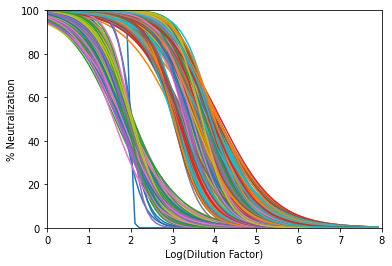

     0     1     2     3     4     5      6     7     8     9   ...    90  \
0    98    83    68    85   108    77     89    81    76    69  ...    71   
1  1219  1079  1349  1237  1285  1592   1427  1172  1230  1289  ...  1297   
2  2288  2682  2969  2623  2406  2266   3306  3024  2869  2603  ...  2940   
3  3271  4214  4437  3293  4454  5308   5255  4833  4819  5192  ...  5061   
4  5493  5101  5100  5686  4548  5008   5196  7298  4548  6601  ...  5619   
5  8253  9768  9475  8736  8200  8913  12272  7830  6579  7937  ...  8489   

      91    92    93    94    95     96    97    98    99  
0     38    73   109    47    65     61    79    99    85  
1   1655  1340  1017  1625  1085   1447  1468  1640  1554  
2   2458  2349  2880  1924  3192   3314  2066  2608  2942  
3   7094  3951  6375  4017  4749   4968  3681  3816  4758  
4   4400  6471  5239  4730  5519   6124  4991  5926  5012  
5  12362  7285  8284  8673  7358  10126  9174  8542  8126  

[6 rows x 100 columns]
       0      1 

In [10]:
###Repeat experiment x times: (generation and fitting)
###The function to fit, and two functions if hill exceeds bounds
##Normal fit
def logistic_curve(logx, logIC50, Hill):
    return 100 / (1 + 10**((logIC50-np.asarray(logx))*Hill))
##Low bound exceeded
def logistic_low_bound(logx, logIC50):
    return 100 / (1 + 10**((logIC50-np.asarray(logx))*(hill_lowerbound)))
##High bound exceeded
def logistic_high_bound(logx, logIC50):
    return 100 / (1 + 10**((logIC50-np.asarray(logx))*(hill_highbound)))
##Calculate residuals
def residuals(param, xs, ys):
    return (100 / (1 + 10**((param[0]-np.asarray(xs))*param[1])))-ys

###Lists to fill
df_IC50_listAll = pd.DataFrame()
df_Hills_listAll = pd.DataFrame()

for repeat in range(100):
    #####PART I: Generate real y_values
    ###generate 'real y' %neutralization based on choosen ic50, hill and the curve
    def neutr_curve(xvalues, ic50 , hill):
        y = 100 / (1 + 10**((np.log10(ic50)-np.asarray(xvalues))*hill))
        return y

    ###Make Dataframe, append based on number of curves (number if IC50's chosen): REAL Y VALUES
    df_y_real = pd.DataFrame()
    for sample in range(len(l_IC50)):##loop for number of curves
        list_y_real = neutr_curve(logdil, l_IC50[sample], l_Hill[sample])
        df_y_real[sample] = list_y_real

    #####PART II: Simulate sample y_values
    ###generate sample data based on real Y and stdev function
    ###Function to generate standard deviation based on %neutralization ##corrected for %neutralization instead of RLU value, linear function !stdev are very variable. this formula is a rough estimation.
    def stdevs(neutr):
        stdev = (-0.1471*neutr) + 16.835
        return stdev

    ###Make dataframe containing simulated data, add ctr too. Each column contains controls and datapoints for one sample.
    df_y_sample = pd.DataFrame()
    for sample in range(len(l_IC50)):##loop for number of curves
        list_y_sample = []
        for i in ctr_cellOnly:
            list_y_sample.append(100*normalize(i))
        for repli in range(len(df_y_real[sample])):##loop for number of values of curve
            datapoints = np.random.normal(df_y_real[sample][repli], stdevs(df_y_real[sample][repli]), replicates)##list with datapoint for a single x value
            for i in datapoints:
                list_y_sample.append(i)
        for i in ctr_Cellpp:
            list_y_sample.append(100*normalize(i))  
        df_y_sample[sample] = list_y_sample

    ###Make list with x-values: Add ctrs too. list contains replicated xvalues for each datapoint as to have the same length as a sample column
    logdil_complete=[]
    for i in ctr_cellOnly:
        logdil_complete.append(0)
    for x in logdil:
        for r in range(replicates):
            logdil_complete.append(x)
    for i in ctr_Cellpp:
        logdil_complete.append(8)

    #####PART III: fit the curve
    IC50_listAll = []
    Hills_listAll = []
    for index in range(len(l_IC50)):###number of samples, iterate through samples in df      
        ##Fit curve to data of sample
        if l1_loss == False:
            parameters, covariancem = curve_fit(logistic_curve, logdil_complete, df_y_sample[index], maxfev=5000, p0=[3,-1])
        elif l1_loss == True:
            soft_l1 = least_squares(residuals, [3,-1], loss='soft_l1', f_scale=15, args=(logdil_complete, df_y_sample[index]))    
            parameters = [soft_l1.x[0], soft_l1.x[1]]
        ##If hill slope should be restricted following part will run
        if hillrestrict == True:
            if parameters[1] < hill_lowerbound:
                parameters, covariancem = curve_fit(logistic_low_bound, logdil_complete, df_y_sample[index], maxfev=5000, p0=[3])
                parameters = np.append(parameters, hill_lowerbound)
            elif parameters[1] > hill_highbound:
                parameters, covariancem = curve_fit(logistic_high_bound, logdil_complete, df_y_sample[index], maxfev=5000, p0=[3])
                parameters = np.append(parameters, hill_highbound)
        ##Add determined parameters to respective list
        IC50_listAll.append(int(10**parameters[0]))
        Hills_listAll.append("%.2f"%parameters[1])
        ##Plot curve: make x value line, define curve with this line and detemrined parameters (ic50 and hill)
        line = np.arange(0, 8, 0.1)
        curve = logistic_curve(line, parameters[0], parameters[1])
        plt.plot(line, curve)
        plt.ylim(0, 100)
        plt.xlabel("Log(Dilution Factor)")
        plt.ylabel("% Neutralization")
        plt.xlim(0, 8)
    df_IC50_listAll[repeat]= IC50_listAll
    df_Hills_listAll[repeat]=Hills_listAll
plt.show()
print(df_IC50_listAll)
print(df_Hills_listAll)

In [11]:
#####PART IV: Save results to csv
path = ("G:/EMPLOYEES/eheerwegh/GIT_Traineeship/3_Simulate&Fit/resultsfiles/IC50_startdil"+str(startdil)+"_dils"+str(dilutions)+"_dilFact"+str(seriesfactor)+"_replic"+str(replicates)+"_restrictHill"+str(hillrestrict)+"_l1"+str(l1_loss)+".csv")
print(path)
df_IC50_listAll.to_csv(path, sep=";")

path2 = ("G:/EMPLOYEES/eheerwegh/GIT_Traineeship/3_Simulate&Fit/resultsfiles/Hill_startdil"+str(startdil)+"_dils"+str(dilutions)+"_dilFact"+str(seriesfactor)+"_replic"+str(replicates)+"_restrictHill"+str(hillrestrict)+"_l1"+str(l1_loss)+".csv")
print(path2)
df_Hills_listAll.to_csv(path2, sep=";")

G:/EMPLOYEES/eheerwegh/GIT_Traineeship/3_Simulate&Fit/resultsfiles/IC50_startdil100_dils8_dilFact3_replic3_restrictHillFalse_l1False.csv
G:/EMPLOYEES/eheerwegh/GIT_Traineeship/3_Simulate&Fit/resultsfiles/Hill_startdil100_dils8_dilFact3_replic3_restrictHillFalse_l1False.csv


21.474739760389273
The estimated IC50 of curve is 8126 (8040 - 8213) the real IC50 is 8340


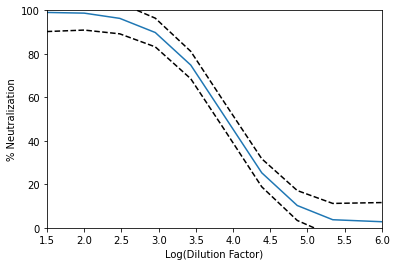

In [12]:
###PART I: Calculating Confidence interval  ###This will be calculated for very last curve of the iterations since the needed variables will contain the info about the las curve done
##Generate the curve with just the experiment-used x-values
curve = logistic_curve(logdil_complete, parameters[0], parameters[1])

##calculate usefull parameters
DF = len(logdil_complete)-2 #Degrees of freedom
tval = stats.t.ppf(0.05, DF) #t-val for a confidence interval of 95%
avr_x = mean(logdil_complete) #Average x-value
SSxx = 0 #Set 'sum of squares of x' initialy to 0
for xval in logdil_complete:
    blup = (xval-avr_x)**2 #calculate squares of x
    SSxx += blup #add to sum of squares of x

avr_y = mean(df_y_sample[5])
sumsqr_ys = 0
for yval in df_y_sample[5]:
    plusje = (yval - avr_y)**2
    sumsqr_ys += plusje

sumsqr_xny = 0
for plup in range(len(logdil_complete)):
    plop = (logdil_complete[plup]-avr_x)*(df_y_sample[5][plup]-avr_y)
    sumsqr_xny += plop
sumsqr_xny = sumsqr_xny**2

SSE = np.sqrt( (1/DF) * ( sumsqr_ys - (sumsqr_xny/SSxx) ) )
print(SSE)

###Part II: Calculating Confidence Interval
s2_low = []
s2_high = []
for i in range(len(logdil_complete)):
    ci_add = tval*SSE*np.sqrt( (1/len(logdil_complete)) + (((logdil_complete[i]-avr_x)**2)/SSxx) )
    ci_low = curve[i] - ci_add  
    ci_high = curve[i] + ci_add  
    s2_low.append(ci_low)
    s2_high.append(ci_high)

###Test Test Test; propably not really correct way to compute, will check later!!!
SE_ic50 = np.sqrt( (sumsqr_ys/DF)*10**covariancem[0,0] )

###Plot curve and CI
plt.plot(logdil_complete, curve)
plt.plot(logdil_complete, s2_low, 'k--')
plt.plot(logdil_complete, s2_high, 'k--')
plt.ylim(0, 100)
plt.xlabel("Log(Dilution Factor)")
plt.ylabel("% Neutralization")
plt.xlim(1.5, 6)

##print results
IC50calc = 10**parameters[0]
print("The estimated IC50 of curve is %.0d" %IC50calc, "(%.0d - %.0d)" %(IC50calc-(SE_ic50*1.959), IC50calc+(SE_ic50*1.959)), "the real IC50 is %.0d" % l_IC50[5])
#print("considering the stDev, the IC50 value may lie between %.0d and %.0d" %())